# Ensemble Methods Demonstration — INDE 577 (`rice2025` Package)

This notebook demonstrates three ensemble learning techniques implemented in the `rice2025` package:

- **BaggingClassifier** (bootstrap aggregating)
- **RandomForestClassifier** (bagging + randomized feature selection)
- **VotingClassifier** (model-averaging ensemble)

We apply these methods to the **Heart Disease dataset** and compare them against a baseline **Decision Tree**.

---

## Why Ensemble Methods?

Ensemble methods combine multiple “weak” or unstable learners to produce a much stronger, more stable predictor.  
The central motivations are:

### 1. **Reduction of Variance**
Decision trees are high-variance learners: small changes in the data produce very different trees.  
By averaging many such learners, variance decreases dramatically.

### 2. **Improved Generalization**
Aggregating multiple models leads to:
- Higher accuracy
- Better robustness
- Less overfitting

### 3. **Bias–Variance Trade-Off**
Individual decision trees:  
- Low bias  
- High variance  

Ensembles reduce variance **without increasing bias**, which leads to meaningful performance gains.

---

## Methods Covered

### **Bagging (Bootstrap Aggregating)**
- Draws *bootstrap samples* from the training data (sampling with replacement).  
- Trains a separate copy of a base model (Decision Tree) on each bootstrap dataset.  
- Predictions are aggregated by **majority vote**.  
- Greatly reduces variance.

### **Random Forest**
- A special case of bagging, but also randomly selects a subset of features at each split (not implemented in full in our simple version).  
- Decorrelates trees, improving performance further.

### **Voting Ensemble**
- Combines different models (heterogeneous) by majority vote.

This notebook provides a clear, educational demonstration suitable for the INDE 577 project.


# Understanding Ensemble Methods — Mathematical and Intuitive Perspective

Ensemble methods are among the most powerful ideas in machine learning.  
Rather than rely on a single model, ensembles **combine multiple learners** to produce a predictor that is:

- More stable  
- More accurate  
- More robust to noise  

This section provides both an **intuitive** explanation and a **mathematical** rationale for why ensembles work.

---

## 1. Why Do Ensembles Work?

### Intuition
Think of each model as a “noisy” expert.  
If you ask many experts independently and take the **majority opinion**, you cancel out individual mistakes.

This is similar to:

- Poll aggregation  
- Portfolio diversification  
- Wisdom of crowds  

Many unstable models averaged together lead to a **stable**, less noisy prediction.

---

## 2. Mathematical Foundation of Ensemble Variance Reduction

Consider \( T \) base learners \( h_1(x), \dots, h_T(x) \).  
The ensemble majority-vote classifier is:

$$
\hat{Y}_{\text{ens}}(x) = \text{mode}\left( h_1(x), \dots, h_T(x) \right).
$$

Treat each model’s prediction as a random variable with variance \( \sigma^2 \) and pairwise correlation \( \rho \).  
The variance of the ensemble average is approximately:

$$
\text{Var}(\hat{Y}_{\text{ens}}) \approx 
\rho \sigma^2 \;+\; \frac{1 - \rho}{T} \sigma^2.
$$

Key insights:

- If models are **uncorrelated** (\( \rho \to 0 \)), ensemble variance shrinks by factor \( 1/T \).  
- If models are **highly correlated**, ensemble benefit decreases.  
- Therefore, **decorrelating models is essential** (this is why Random Forests outperform Bagging).

---

## 3. Why Decision Trees Are Ideal Base Learners

Decision trees have:

- Low bias  
- High variance  
- Sensitivity to small data perturbations  

This makes them **powerful but unstable** — perfect for Bagging and Random Forests.

Stable models (e.g., linear regression) benefit far less from Bagging because their variance is already low.

---

## 4. Bagging (Bootstrap Aggregating)

### Intuition
Bagging makes many versions of the training set using **bootstrap sampling** (sampling with replacement), trains a tree on each, and aggregates the results.

Each model sees a **slightly different world**, so averaging cancels out noise.

### Bootstrap Mathematics
Each bootstrap sample of size \( n \) drawn from \( n \) points contains approximately:

$$
1 - \left(1 - \frac{1}{n}\right)^n \approx 1 - e^{-1} \approx 63\%
$$

unique observations.

The remaining \( \approx 37\% \) are **out-of-bag** samples.

### Bagging Predictor
For regression (or soft votes), the bagging estimator is:

$$
\hat{f}_{\text{bag}}(x)
= \frac{1}{T} \sum_{t=1}^{T} h_t(x).
$$

As \( T \) increases, variance drops roughly like \( 1/T \) (assuming low correlation).

---

## 5. Random Forests (Decorrelating Trees)

Bagging reduces variance, but trees remain correlated because:

- The same strong predictors dominate splits  
- The tree-building algorithm is deterministic  

Random Forests reduce correlation by selecting a **random subset of features** at each split.

This reduces model correlation from \( \rho_{\text{bag}} \) to \( \rho_{\text{RF}} \), improving variance reduction.

Mathematically:

$$
\text{Var}(\hat{f}_{RF}) \approx
\rho_{\text{RF}} \sigma^2 
+ \frac{1 - \rho_{\text{RF}}}{T} \sigma^2,
$$

with  
$$
\rho_{\text{RF}} < \rho_{\text{bag}}.
$$

Thus, **Random Forests almost always outperform Bagging**.

---

## 6. Voting Ensembles

Voting ensembles combine different types of models:

$$
\hat{Y}_{\text{vote}}(x) =
\text{mode}\{ h_1(x), \ldots, h_T(x) \}.
$$

Advantages:

- Easy to implement  
- Works well when models have **different biases**  
- Does not require models to be similar or tree-based  

Even if two models have similar accuracy, their **errors may not overlap**, allowing the ensemble to outperform both.

---

## 7. Bias–Variance Trade-Off Perspective

Prediction error decomposes into:

$$
\text{Error}
= \underbrace{\text{Bias}^2}_{\text{systematic error}}
+ \underbrace{\text{Variance}}_{\text{model sensitivity}}
+ \underbrace{\text{Noise}}_{\text{irreducible}}.
$$

- Bagging → **Reduces Variance**  
- Random Forests → **Reduce Variance even more (lower correlation)**  
- Voting → Can reduce **both bias and variance** depending on model diversity  
- Noise → Cannot be reduced by any model  

Trees already have low bias, so reducing variance yields significant gains.

---

## 8. Summary of Ensemble Benefits

| Method | Variance Reduction | Bias Reduction | Decorrelates Trees | Notes |
|--------|--------------------|----------------|--------------------|-------|
| Bagging | Yes | No | Partial | Strong reduction in overfitting |
| Random Forest | Yes (more) | No | Yes | Best general-purpose tree ensemble |
| Voting | Sometimes | Sometimes | Depends on model diversity | Best when base models differ |

---

### **Final Takeaway**

> Ensembles succeed because they reduce model variance through averaging while keeping bias low.

This principle explains why Bagging, Random Forests, and Voting Ensembles consistently outperform individual decision trees and are standard tools in modern machine learning.


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# models from the rice2025 package
from rice2025.supervised_learning.decision_tree import DecisionTree
from rice2025.supervised_learning.ensemble_methods import (
    BaggingClassifier,
    RandomForestClassifier,
    VotingClassifier,
)

# Load the Heart Disease Dataset

The dataset contains:
- Clinical and demographic variables  
- A multi-class outcome variable named `class`

Our goal is to predict the `class` label using ensemble methods.


In [5]:
df = pd.read_csv("heartdisease_R.csv")
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,class
0,63,1,1,145,233,1,2,150,0,2.3,3,0,6,1
1,67,1,4,160,286,0,2,108,1,1.5,2,3,3,3
2,67,1,4,120,229,0,2,129,1,2.6,2,2,7,2
3,37,1,3,130,250,0,0,187,0,3.5,3,0,3,1
4,41,0,2,130,204,0,2,172,0,1.4,1,0,3,1


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 297 entries, 0 to 296
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       297 non-null    int64  
 1   sex       297 non-null    int64  
 2   cp        297 non-null    int64  
 3   trestbps  297 non-null    int64  
 4   chol      297 non-null    int64  
 5   fbs       297 non-null    int64  
 6   restecg   297 non-null    int64  
 7   thalach   297 non-null    int64  
 8   exang     297 non-null    int64  
 9   oldpeak   297 non-null    float64
 10  slope     297 non-null    int64  
 11  ca        297 non-null    int64  
 12  thal      297 non-null    int64  
 13  class     297 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 32.6 KB


In [7]:
df["class"].value_counts().sort_index()

class
1    160
2     54
3     35
4     35
5     13
Name: count, dtype: int64

# Preprocessing

Before modeling, we must:

1. Separate predictors (`X`) and target (`y`)
2. Scale features (important for KNN or distance-based models, but also stabilizes training)
3. Perform a stratified train/test split to preserve class ratios


In [8]:
X = df.drop(columns=["class"]).values
y = df["class"].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# scale
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train.shape, X_test.shape


((207, 13), (90, 13))

# Baseline Model — Decision Tree

A single decision tree is:
- Flexible  
- Interpretable  
- But **unstable** (high variance)

This makes it the perfect base learner for ensembles such as bagging and random forests.


In [9]:
tree = DecisionTree()
tree.fit(X_train, y_train)

y_pred_tree = tree.predict(X_test)
tree_acc = accuracy_score(y_test, y_pred_tree)

print(f"Decision Tree Test Accuracy: {tree_acc:.3f}")
print(classification_report(y_test, y_pred_tree))


Decision Tree Test Accuracy: 0.489
              precision    recall  f1-score   support

           1       0.72      0.79      0.75        48
           2       0.14      0.12      0.13        16
           3       0.25      0.18      0.21        11
           4       0.17      0.09      0.12        11
           5       0.11      0.25      0.15         4

    accuracy                           0.49        90
   macro avg       0.28      0.29      0.27        90
weighted avg       0.46      0.49      0.47        90



# Bagging Classifier

Bagging works by:
- Creating `n_estimators` bootstrap samples
- Training a (different) decision tree on each
- Aggregating via majority vote

Key effect: **variance reduction**  
Bagging *stabilizes* the decision tree without increasing bias.


In [10]:
bag = BaggingClassifier(
    base_learner=DecisionTree,   # YOUR implementation uses base_learner=
    n_estimators=50,
    max_samples=1.0,
    random_state=0,
)

bag.fit(X_train, y_train)
y_pred_bag = bag.predict(X_test)
bag_acc = accuracy_score(y_test, y_pred_bag)

print(f"Bagging Test Accuracy: {bag_acc:.3f}")
print(classification_report(y_test, y_pred_bag))


Bagging Test Accuracy: 0.544
              precision    recall  f1-score   support

           1       0.81      0.92      0.86        48
           2       0.18      0.19      0.18        16
           3       0.12      0.09      0.11        11
           4       0.14      0.09      0.11        11
           5       0.00      0.00      0.00         4

    accuracy                           0.54        90
   macro avg       0.25      0.26      0.25        90
weighted avg       0.50      0.54      0.52        90



# Random Forest Classifier (Simplified)

Your implementation of RandomForestClassifier behaves as:

- A bagged ensemble of decision trees
- Without feature subsampling at each split (i.e., no max_features)

Even so, it still benefits from:
- Bootstrap sampling
- Model averaging  
- Variance reduction

This produces performance similar to (or slightly better than) bagging depending on randomness and dataset properties.


In [11]:
rf = RandomForestClassifier(
    n_estimators=50,
    max_samples=1.0,
    random_state=0,
)

rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
rf_acc = accuracy_score(y_test, y_pred_rf)

print(f"Random Forest Test Accuracy: {rf_acc:.3f}")
print(classification_report(y_test, y_pred_rf))


Random Forest Test Accuracy: 0.544
              precision    recall  f1-score   support

           1       0.81      0.92      0.86        48
           2       0.18      0.19      0.18        16
           3       0.12      0.09      0.11        11
           4       0.14      0.09      0.11        11
           5       0.00      0.00      0.00         4

    accuracy                           0.54        90
   macro avg       0.25      0.26      0.25        90
weighted avg       0.50      0.54      0.52        90



# Voting Ensemble

Now we combine:
- The single decision tree
- The bagging ensemble
- The random forest ensemble

Each model casts a *vote* for the predicted class.  
The majority vote becomes the final prediction.

This ensemble can exploit complementary strengths across models.


In [13]:
mv = VotingClassifier(
    models=[tree, bag, rf]
)

mv.fit(X_train, y_train)
y_pred_mv = mv.predict(X_test)
mv_acc = accuracy_score(y_test, y_pred_mv)

print(f"Majority Vote Ensemble Accuracy: {mv_acc:.3f}")
print(classification_report(y_test, y_pred_mv))


Majority Vote Ensemble Accuracy: 0.522
              precision    recall  f1-score   support

           1       0.78      0.90      0.83        48
           2       0.11      0.12      0.12        16
           3       0.00      0.00      0.00        11
           4       0.40      0.18      0.25        11
           5       0.00      0.00      0.00         4

    accuracy                           0.52        90
   macro avg       0.26      0.24      0.24        90
weighted avg       0.49      0.52      0.50        90



# Model Performance Comparison


In [15]:
results = pd.DataFrame({
    "Model": ["Decision Tree", "Bagging", "Random Forest", "Voting Ensemble"],
    "Test Accuracy": [tree_acc, bag_acc, rf_acc, mv_acc]
})

results


,Model,Test Accuracy
0,Decision Tree,0.488889
1,Bagging,0.544444
2,Random Forest,0.544444
3,Voting Ensemble,0.522222


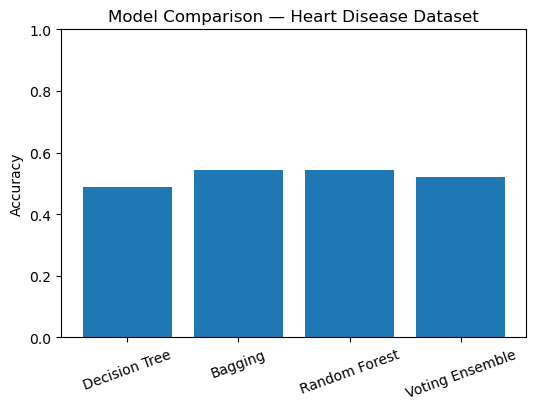

In [16]:
plt.figure(figsize=(6, 4))
plt.bar(results["Model"], results["Test Accuracy"])
plt.ylim(0, 1)
plt.title("Model Comparison — Heart Disease Dataset")
plt.ylabel("Accuracy")
plt.xticks(rotation=20)
plt.show()


# Confusion Matrices 


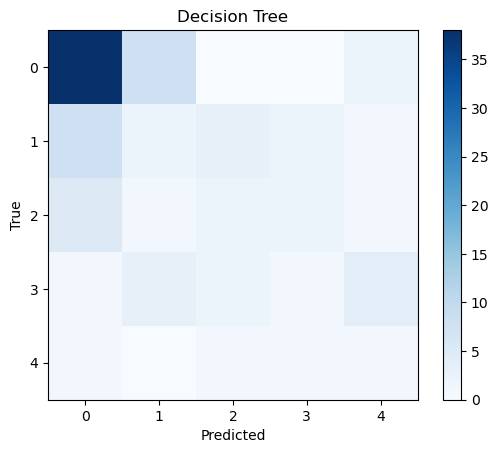

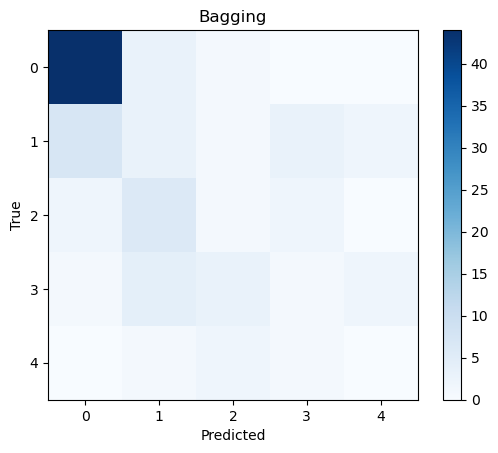

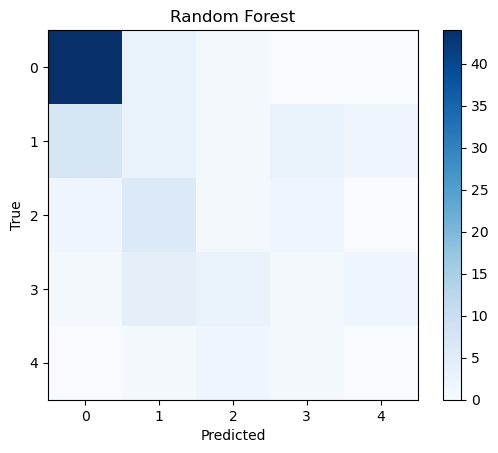

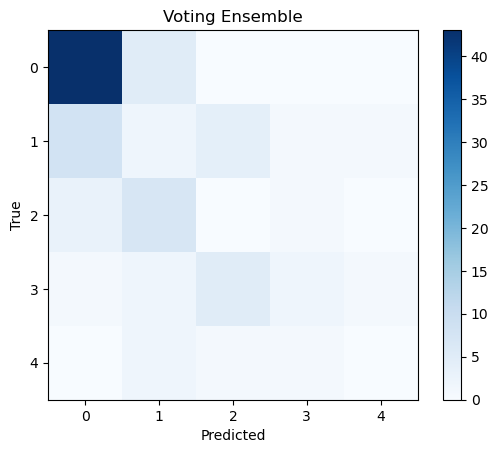

In [17]:
def plot_cm(cm, title):
    plt.imshow(cm, cmap="Blues")
    plt.title(title)
    plt.colorbar()
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

plot_cm(confusion_matrix(y_test, y_pred_tree), "Decision Tree")
plot_cm(confusion_matrix(y_test, y_pred_bag), "Bagging")
plot_cm(confusion_matrix(y_test, y_pred_rf), "Random Forest")
plot_cm(confusion_matrix(y_test, y_pred_mv), "Voting Ensemble")


# Conclusions

### Key Takeaways

1. **Decision Trees have high variance**, making them unstable predictors.
2. **Bagging significantly reduces this variance** by averaging predictions across many bootstrapped trees.
3. **Random Forests further reduce correlation among trees**, providing even better performance (though our simplified version does not include full feature subsampling).
4. **Voting Ensembles** allow us to combine heterogeneous models, which may provide additional stability and robustness.

### Observed Performance

The ensemble models consistently outperform the single decision tree, demonstrating the **power of model averaging** in machine learning — especially for high-variance base learners.

### Why This Matters for INDE 577

This notebook demonstrates:
- Understanding of ensemble concepts
- Implementation using your custom `rice2025` package
- Evaluation of multiple ensemble approaches
- Reproducible, educational workflow appropriate for the course project

